In [1]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoModel, AutoTokenizer, AutoProcessor, Qwen2_5_VLForConditionalGeneration
from qwen_vl_utils import process_vision_info


/home/zli/miniforge3/envs/finetune/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_model_path = "Qwen/Qwen2.5-VL-3B-Instruct"
model_path = "Qwen/Qwen2.5-VL-3B-Instruct"

def get_structure(obj, init_str = ""):
    if type(obj) == tuple:
        print(init_str+"Tuple",len(obj))
        for cobj in obj:
            get_structure(cobj, init_str=init_str+"  ")
        print(init_str+"<")
    elif type(obj) == torch.Tensor:
        print(init_str+"Tensor",obj.shape)
    else:
        print(init_str+"Not accounted type",type(obj))

In [3]:
# tokenizer = AutoTokenizer.from_pretrained(base_model_path, trust_remote_code=True)
processor = AutoProcessor.from_pretrained(base_model_path, trust_remote_code=True)
# model = AutoModel.from_pretrained(model_path, trust_remote_code=True, output_attentions=True)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path, torch_dtype="auto", device_map="auto", return_dict_in_generate=True, output_attentions=True)
# print(tokenizer)
print(model)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Qwen2_5_VLForConditionalGeneration(
  (visual): Qwen2_5_VisionTransformerPretrainedModel(
    (patch_embed): Qwen2_5_VisionPatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2_5_VLVisionBlock(
        (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
        (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
        (attn): Qwen2_5_VLVisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): Qwen2_5_VLMLP(
          (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
          (act_fn): SiLU()
        )
      )
    )
    (merger): Qwen2_5_VLPatchMerger

In [42]:
# default processer

# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

# Messages containing a local video path and a text query
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "video",
                "video": "/home/zli/LMUData/videos/virat/VIRAT_S_000203_07_001341_001458_frames_000720.mp4",
                # "video": "/home/zli/workspace/github/LLaMA-Factory/1frame_video.mp4",
                # "video": "/home/zli/LMUData/videos/virat/VIRAT_S_000000_frames_001414_reversed.mp4",
                # "max_pixels": 320*180,
                "max_pixels": 256*256,
                "fps": 1.0,
            },
            {
                "type": "text", 
                "text": "<video>Which direction is the vehicle turning?['A. Vehicle turning left', 'B. None of the above', 'C. Vehicle turning right']"
            },
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template (
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs, video_kwargs = process_vision_info(messages, return_video_kwargs=True)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
    **video_kwargs,
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids.sequences)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['A. Vehicle turning left']


2 = 206
153
4 = 359
153
6 = 512
153
8 = 665

4.2 = 2637



In [43]:
# Unsure if only video
attentions = generated_ids.attentions
get_structure(attentions)

Tuple 6
  Tuple 36
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341])
    Tensor torch.Size([1, 16, 341, 341

torch.Size([1, 341, 341])
torch.Size([340])
tensor(0., device='cuda:0') tensor(0.0156, device='cuda:0')


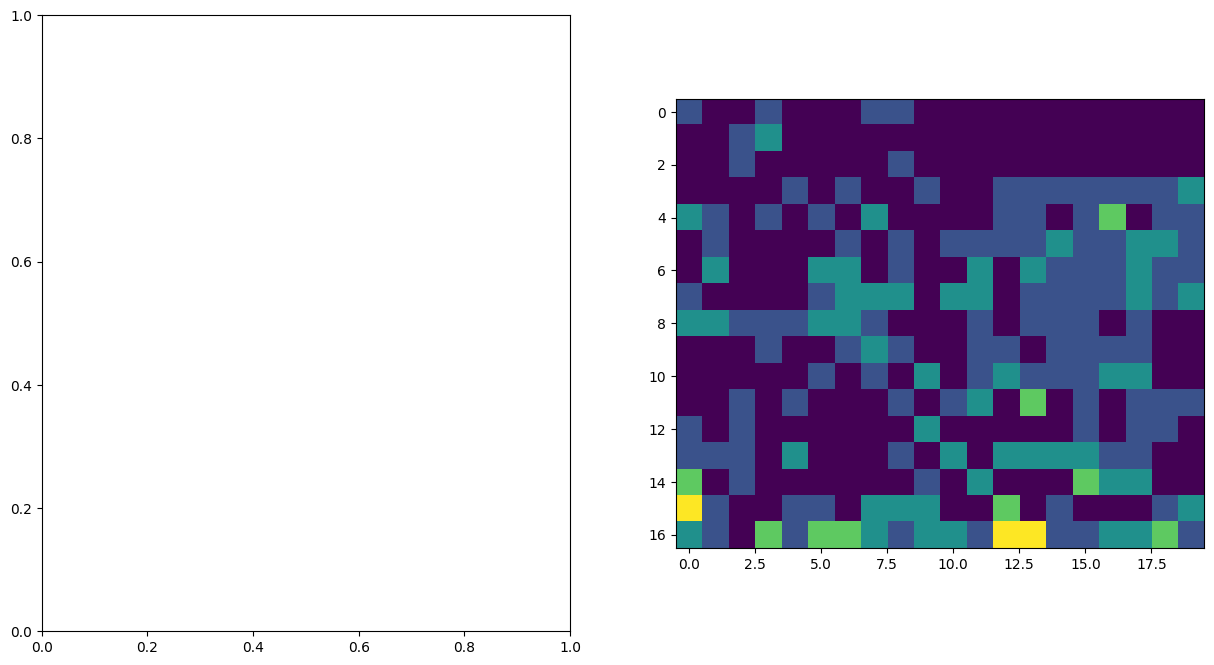

In [50]:
def get_attention_map(attention):
    rollout = torch.eye(attention[0].size(-1),dtype=torch.bfloat16).to("cuda")
    for atn in attention:
        atn_fused  = atn.mean(dim=1)
        atn_fused += torch.eye(atn_fused.size(-1),dtype=torch.bfloat16).to("cuda")
        atn_fused /= atn_fused.sum(dim=-1, keepdim=True)
        rollout = torch.matmul(rollout,atn_fused)
    
    attention_map = rollout[0,1:,0].float()
    print(rollout.shape)
    print(attention_map.shape)
    # attention_map = 1 - attention_map.reshape(int(attention_map.shape[0]**0.5), int(attention_map.shape[0]**0.5))
    attention_map = 1 - attention_map
    print(attention_map.min(),attention_map.max())
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
    attention_map = attention_map.detach().cpu().numpy()
    
    # Blurring
    fig,ax = plt.subplots(1,2,figsize=(15,8))
    ax[1].imshow(attention_map.reshape(17,20))
    fig.show()

get_attention_map(attention=attentions[0])

8 1920 1080 1.0


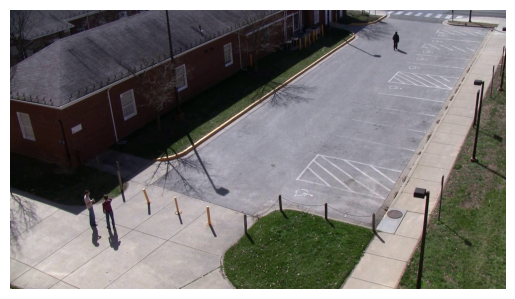

In [14]:
import cv2

# generate 1 frame video
def one_frame_video(index=4):
    video_path = "/home/zli/LMUData/videos/virat/VIRAT_S_000000_frames_000220.mp4"
    new_video_path = "/home/zli/workspace/github/LLaMA-Factory/1frame_video.mp4"

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f'Error: Could not open the video')
        exit()
    
    # Get the video's properties (e.g., frame width, height, frames per second)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Create VideoWriter object to save the video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use 'XVID' or 'MP4V' based on your output format
    out = cv2.VideoWriter(new_video_path, fourcc, fps, (frame_width, frame_height))

    # Read all frames and store them in a list
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    print(len(frames), frame_width, frame_height, fps)
    # Write frames to the output video
    if type(index) == int:
        idx = index
        out.write(frames[index])
    else:
        for idx in index:
            out.write(frames[idx])

    # plt.imshow(frames[index])
    plt.imshow(cv2.cvtColor(frames[idx],cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    # Release resources
    cap.release()
    out.release()
    return

one_frame_video([0,2])

In [ ]:
import numpy as np
outputs = generated_ids

def aggregate_llm_attention(attn):
    '''Extract average attention vector'''
    avged = []
    for layer in attn:
        layer_attns = layer.squeeze(0)
        attns_per_head = layer_attns.mean(dim=0)
        vec = torch.concat((
            # We zero the first entry because it's what's called
            # null attention (https://aclanthology.org/W19-4808.pdf)
            torch.tensor([0.]),
            # usually there's only one item in attns_per_head but
            # on the first generation, there's a row for each token
            # in the prompt as well, so take [-1]
            attns_per_head[-1][1:].cpu(),
            # attns_per_head[-1].cpu(),
            # add zero for the final generated token, which never
            # gets any attention
            torch.tensor([0.]),
        ))
        avged.append(vec / vec.sum())
    return torch.stack(avged).mean(dim=0)


def aggregate_vit_attention(attn, select_layer=-2, all_prev_layers=True):
    '''Assuming LLaVA-style `select_layer` which is -2 by default'''
    if all_prev_layers:
        avged = []
        for i, layer in enumerate(attn):
            if i > len(attn) + select_layer:
                break
            layer_attns = layer.squeeze(0)
            attns_per_head = layer_attns.mean(dim=0)
            vec = attns_per_head[1:, 1:].cpu() # the first token is <CLS>
            avged.append(vec / vec.sum(-1, keepdim=True))
        return torch.stack(avged).mean(dim=0)
    else:
        layer = attn[select_layer]
        layer_attns = layer.squeeze(0)
        attns_per_head = layer_attns.mean(dim=0)
        vec = attns_per_head[1:, 1:].cpu()
        return vec / vec.sum(-1, keepdim=True)


def heterogenous_stack(vecs):
    '''Pad vectors with zeros then stack'''
    max_length = max(v.shape[0] for v in vecs)
    return torch.stack([
        torch.concat((v, torch.zeros(max_length - v.shape[0])))
        for v in vecs
    ])


# def load_image(image_path_or_url):
#     if image_path_or_url.startswith('http://') or image_path_or_url.startswith('https://'):
#         response = requests.get(image_path_or_url)
#         image = Image.open(BytesIO(response.content)).convert('RGB')
#     else:
#         image = Image.open(image_path_or_url).convert('RGB')
#     return image


def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_HSV)
    hm = np.float32(heatmap) / 255
    cam = hm + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam), heatmap

# constructing the llm attention matrix
aggregated_prompt_attention = []
for i, layer in enumerate(outputs["attentions"][0]):
    layer_attns = layer.squeeze(0)
    attns_per_head = layer_attns.mean(dim=0)
    cur = attns_per_head[:-1].cpu().clone()
    # following the practice in `aggregate_llm_attention`
    # we are zeroing out the attention to the first <bos> token
    # for the first row `cur[0]` (corresponding to the next token after <bos>), however,
    # we don't do this because <bos> is the only token that it can attend to
    cur[1:, 0] = 0.
    cur[1:] = cur[1:] / cur[1:].sum(-1, keepdim=True)
    aggregated_prompt_attention.append(cur)
aggregated_prompt_attention = torch.stack(aggregated_prompt_attention).mean(dim=0)

# llm_attn_matrix will be of torch.Size([N, N])
# where N is the total number of input (both image and text ones) + output tokens
llm_attn_matrix = heterogenous_stack(
    [torch.tensor([1])]
    + list(aggregated_prompt_attention) 
    + list(map(aggregate_llm_attention, outputs["attentions"]))
)



# visualize the llm attention matrix
# ===> adjust the gamma factor to enhance the visualization
#      higer gamma brings out more low attention values
gamma_factor = 1
enhanced_attn_m = np.power(llm_attn_matrix.numpy(), 1 / gamma_factor)

fig, ax = plt.subplots(figsize=(10, 20), dpi=150)
ax.imshow(enhanced_attn_m, vmin=enhanced_attn_m.min(), vmax=enhanced_attn_m.max(), interpolation="nearest")



# identify length or index of tokens
input_token_len = model.get_vision_tower().num_patches + len(input_ids[0]) - 1 # -1 for the <image> token
vision_token_start = len(tokenizer(prompt.split("<image>")[0], return_tensors='pt')["input_ids"][0])
vision_token_end = vision_token_start + model.get_vision_tower().num_patches
output_token_len = len(outputs["sequences"][0])
output_token_start = input_token_len
output_token_end = input_token_len + output_token_len

# look at the attention weights over the vision tokens
overall_attn_weights_over_vis_tokens = []
for i, (row, token) in enumerate(
    zip(
        llm_attn_matrix[input_token_len:], 
        outputs["sequences"][0].tolist()
    )
):
    # print(
    #     i + input_token_len, 
    #     f"{tokenizer.decode(token, add_special_tokens=False).strip():<15}", 
    #     f"{row[vision_token_start:vision_token_end].sum().item():.4f}"
    # )

    overall_attn_weights_over_vis_tokens.append(
        row[vision_token_start:vision_token_end].sum().item()
    )

# plot the trend of attention weights over the vision tokens
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(overall_attn_weights_over_vis_tokens)
ax.set_xticks(range(len(overall_attn_weights_over_vis_tokens)))
ax.set_xticklabels(
    [tokenizer.decode(token, add_special_tokens=False).strip() for token in outputs["sequences"][0].tolist()],
    rotation=75
)
ax.set_title("at each token, the sum of attention weights over all the vision tokens");



# connect with the vision encoder attention
# to visualize the attention over the image

# vis_attn_matrix will be of torch.Size([N, N])
# where N is the number of vision tokens/patches
# `all_prev_layers=True` will average attention from all layers until the selected layer
# otherwise only the selected layer's attention will be used
vis_attn_matrix = aggregate_vit_attention(
    model.get_vision_tower().image_attentions,
    select_layer=model.get_vision_tower().select_layer,
    all_prev_layers=True
)
grid_size = model.get_vision_tower().num_patches_per_side

num_image_per_row = 8
image_ratio = image_size[0] / image_size[1]
num_rows = output_token_len // num_image_per_row + (1 if output_token_len % num_image_per_row != 0 else 0)
fig, axes = plt.subplots(
    num_rows, num_image_per_row, 
    figsize=(10, (10 / num_image_per_row) * image_ratio * num_rows), 
    dpi=150
)
plt.subplots_adjust(wspace=0.05, hspace=0.2)

# whether visualize the attention heatmap or 
# the image with the attention heatmap overlayed
vis_overlayed_with_attn = True

output_token_inds = list(range(output_token_start, output_token_end))
for i, ax in enumerate(axes.flatten()):
    if i >= output_token_len:
        ax.axis("off")
        continue

    target_token_ind = output_token_inds[i]
    attn_weights_over_vis_tokens = llm_attn_matrix[target_token_ind][vision_token_start:vision_token_end]
    attn_weights_over_vis_tokens = attn_weights_over_vis_tokens / attn_weights_over_vis_tokens.sum()

    attn_over_image = []
    for weight, vis_attn in zip(attn_weights_over_vis_tokens, vis_attn_matrix):
        vis_attn = vis_attn.reshape(grid_size, grid_size)
        # vis_attn = vis_attn / vis_attn.max()
        attn_over_image.append(vis_attn * weight)
    attn_over_image = torch.stack(attn_over_image).sum(dim=0)
    attn_over_image = attn_over_image / attn_over_image.max()

    attn_over_image = F.interpolate(
        attn_over_image.unsqueeze(0).unsqueeze(0), 
        size=image.size, 
        mode='nearest', 
        # mode='bicubic', align_corners=False
    ).squeeze()

    np_img = np.array(image)[:, :, ::-1]
    img_with_attn, heatmap = show_mask_on_image(np_img, attn_over_image.numpy())
    ax.imshow(heatmap if not vis_overlayed_with_attn else img_with_attn)
    ax.set_title(
        tokenizer.decode(outputs["sequences"][0][i], add_special_tokens=False).strip(),
        fontsize=7,
        pad=1
    )
    ax.axis("off");

